In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
from sklearn.model_selection import train_test_split

import pickle

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
with open("preprocessed_fake_real_data.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

### Feature extraction using TF-IDF vectorizer 

In [3]:
cv = TfidfVectorizer(max_features=20000) # shape (28665, 155161)
X = cv.fit_transform(df['content'].tolist()).toarray()

y=pd.get_dummies(df['type'])
y=y.iloc[:,1].values

In [4]:
# Adding title length into tf-itf vectorize matrix
# X = np.concatenate((X, df[['content_punc_len_per','title_uppercase_len_per']].values.reshape(-1,2)), axis=1) 
# X

In [5]:
X.shape

(28665, 20000)

In [6]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify=y)

### Multinomial Naive Bayes

In [7]:
# Multinomial Naive Bayes with single train-test split
spam_detect_model = MultinomialNB().fit(X_train, y_train)

y_pred=spam_detect_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.8677830106401535


[[2015  576]
 [ 182 2960]]


              precision    recall  f1-score   support

           0       0.92      0.78      0.84      2591
           1       0.84      0.94      0.89      3142

    accuracy                           0.87      5733
   macro avg       0.88      0.86      0.86      5733
weighted avg       0.87      0.87      0.87      5733



In [8]:
# Multinomial Naive Bayes with cross validation
m = MultinomialNB()
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(m, X, y, cv=kfold)
print(scores)
print(scores.mean())

[0.85524939 0.8545518  0.85734217 0.86989885 0.85699337 0.8611305
 0.8555478  0.85275645 0.86741103 0.8649686 ]
0.8595849952694607


In [9]:
# Multinomial Naive Bayes with cross validation and GridSearchCV
param_grid = {'alpha': [1, 1e-2, 1e-3, 1e-10]}

m = MultinomialNB()
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
grid_search = GridSearchCV(m, param_grid, cv=kfold)
grid_search.fit(X_train, y_train)

print("Train Accuracy :",grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

predictions = grid_search.predict(X_test)
print("Test Accuracy :",accuracy_score(y_test, predictions),'\n')


Train Accuracy : 0.8751090179661608
{'alpha': 1e-10}
MultinomialNB(alpha=1e-10, class_prior=None, fit_prior=True)
Test Accuracy : 0.880690737833595 



## Logistic Regression

In [10]:
# With single train test split
clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.9258677830106401


[[2364  227]
 [ 198 2944]]


              precision    recall  f1-score   support

           0       0.92      0.91      0.92      2591
           1       0.93      0.94      0.93      3142

    accuracy                           0.93      5733
   macro avg       0.93      0.92      0.93      5733
weighted avg       0.93      0.93      0.93      5733



In [11]:
# Logistic with cross validation
logreg = LogisticRegression(solver='liblinear')
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(logreg, X, y, cv=kfold)
print(scores)
print(scores.mean())

[0.92465992 0.92256714 0.93547262 0.93686781 0.92256714 0.92637823
 0.93021633 0.92533147 0.91765527 0.93370551]
0.9275421446393752


In [14]:
# Logistic with cross validation and GridSearchCV

param_grid = [{'C': [0.1, 1, 10, 100],
                'penalty': ['l1','l2']  
             }]

m = LogisticRegression(solver='liblinear')
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
grid_search = GridSearchCV(m, param_grid, cv=kfold)
grid_search.fit(X_train, y_train)

print("Train Accuracy :",grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

predictions = grid_search.predict(X_test)
print("Test Accuracy :",accuracy_score(y_test, predictions),'\n')

Train Accuracy : 0.9395168323739752
{'C': 10, 'penalty': 'l2'}
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Test Accuracy : 0.9419152276295133 



### Random Forests

In [15]:
#Random Forest with singal train-test split


m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, n_jobs=-1)
m.fit(X_train, y_train)

predictions = m.predict(X_test)
print(classification_report(y_test, predictions))
print("Accuracy :",accuracy_score(y_test, predictions),'\n')

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      2591
           1       0.84      0.94      0.89      3142

    accuracy                           0.87      5733
   macro avg       0.88      0.86      0.86      5733
weighted avg       0.87      0.87      0.87      5733

Accuracy : 0.8679574393860108 



In [7]:
# Random Forest with cross validation and grid search

param_grid = [{'n_estimators':[30, 40, 100]}]
               
               #'max_features':[6, 10, 12]}

m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, n_jobs=-1)
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
grid_search = GridSearchCV(m, param_grid, cv=kfold)
grid_search.fit(X_train, y_train)

print("Train Accuracy :",grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

predictions = grid_search.predict(X_test)
print("Test Accuracy :",accuracy_score(y_test, predictions),'\n')

Train Accuracy : 0.8761555904413048
{'n_estimators': 100}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
Test Accuracy : 0.8754578754578755 



### ROC AUC Curve

In [8]:
classifiers = [LogisticRegression(solver='liblinear'), 
               MultinomialNB(),
              RandomForestClassifier(n_estimators=100, min_samples_leaf=3, n_jobs=-1)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

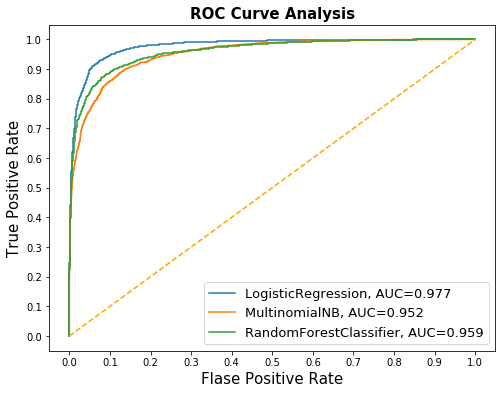

In [9]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()